# Basics of Deep Learning Modelling

## Why Julia?

During this course we will work with [Julia](https://julialang.org/) language. Why?

- It is a script language (just like Python or R)
- Julia is fast (almost like C)
- It have developed [type system](https://upload.wikimedia.org/wikipedia/commons/d/d9/Julia-number-type-hierarchy.svg) 
- Build-in functions for distributed computing and GPU usage.
- Julia is easy to integrate with other languages (Python, R, C, …) 


### Additional materials 

- [Julia Academy](https://juliaacademy.com/)
- [Boyd and Vandenberghe Linear Algebra book](http://vmls-book.stanford.edu/)
- [Julia Express](https://github.com/bkamins/The-Julia-Express)
- [Quantitative Economics lectures by Sargent and Stachursky](https://lectures.quantecon.org/jl/)
- [Julia for Data Science](http://ucidatascienceinitiative.github.io/IntroToJulia/)
- [Think Julia](https://benlauwens.github.io/ThinkJulia.jl/latest/book.html)
- [Other materials avalaible at the language site](https://julialang.org/learning/)

### Packages

####  1. DataFrames.jl

[<tt>DataFrames</tt>](https://dataframes.juliadata.org/stable/) is a package with resources for working with tabular data. It is an implementation of well-known data frames, with all the same tools as in the <tt>R</tt> or <tt>Pandas</tt> library in <tt>Python</tt>. If you want to learn more you could take a look at the [introduction to <tt>DataFrames</tt> ](https://github.com/bkamins/Julia-DataFrames-Tutorial).

#### 2. Plots.jl

[Plots](https://docs.juliaplots.org/latest/tutorial/) is a basic tool for plotting in Julia. The biggest advantage of this package is an access to many different plotting [backends](http://docs.juliaplots.org/latest/backends/). Documentation of <tt>Plots.jl</tt> is avalaible [here](http://docs.juliaplots.org/latest/).

# Introductory  Example

Let start with a simple case study. We will build a basic perceptron for the classification task on the Australian credit scoring data (avalaible [here](http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat)). Our goal is to train a model to distinguish between the good and bad debtors. Obviously, we must start with importing the necessary packages and preparing a data:

In [1]:
using DelimitedFiles
using PyPlot
using Statistics
using StatsBase
using DataFrames

In [2]:
isfile("australian.dat") ||
 download("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat",
         "australian.dat" )
rawdata = readdlm("australian.dat");

In [3]:
df = DataFrames.DataFrame(rawdata,:auto)
rename!(df,:x15 => :class)
df[!,:x4] = [x == 1 ? 1.0 : 0.0 for x in df[!,:x4]]
df[!,:x12] = [x == 1 ? 1.0 : 0.0 for x in df[!,:x12]]
df[!,:x14] = log.(df[!,:x14])
first(df,5)

,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,22.08,11.46,0.0,4.0,4.0,1.585,0.0,0.0
2,0.0,22.67,7.0,0.0,8.0,4.0,0.165,0.0,0.0
3,0.0,29.58,1.75,1.0,4.0,4.0,1.25,0.0,0.0
4,0.0,21.67,11.5,1.0,5.0,3.0,0.0,1.0,1.0
5,1.0,20.17,8.17,0.0,6.0,4.0,1.96,1.0,1.0


In [4]:
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,x1,0.678261,0.0,1.0,1.0,0,Float64
2,x2,31.5682,13.75,28.625,80.25,0,Float64
3,x3,4.75872,0.0,2.75,28.0,0,Float64
4,x4,0.236232,0.0,0.0,1.0,0,Float64
5,x5,7.37246,1.0,8.0,14.0,0,Float64
6,x6,4.69275,1.0,4.0,9.0,0,Float64
7,x7,2.22341,0.0,1.0,28.5,0,Float64
8,x8,0.523188,0.0,1.0,1.0,0,Float64
9,x9,0.427536,0.0,0.0,1.0,0,Float64


In [5]:
countmap(df[!, :class])

Dict{Float64, Int64} with 2 entries:
  0.0 => 383
  1.0 => 307

In [6]:
train_ratio = 0.7

0.7

In [7]:
train_set = df[1:floor(Int,size(df,1)*train_ratio),:];
test_set = df[floor(Int,size(df,1)*train_ratio + 1):end,:];

In [8]:
X_train = Matrix(train_set[:,1:end-1])';
X_test = Matrix(test_set[:,1:end-1])';
y_train = train_set[!, :class];
y_test = test_set[!, :class];

Data should be normalized:

In [9]:
function scale(X)

    μ = mean(X, dims=2)
    σ = std(X, dims=2)

    X_norm = (X .- μ) ./ σ

    return (X_norm, μ, σ);
end

function scale(X, μ, σ)
    X_norm = (X .- μ) ./ σ
    return X_norm;
end

scale (generic function with 2 methods)

In [10]:
X_train, μ, σ = scale(X_train);

In [11]:
X_test = scale(X_test, μ, σ);

Finally we must define the weights of the model and the sigmoidal function:

In [12]:
β = rand(1,size(X_train,1) + 1);

In [13]:
Predict(β, x) = 1 ./ (1 .+ exp.(-β[1:end-1]' * x .- β[end]))

Predict (generic function with 1 method)

In [14]:
Predict(β,X_train)

1×482 Matrix{Float64}:
 0.51314  0.0110774  0.191639  0.164014  …  0.169503  0.926687  0.108795

<b> Binary cross-entropy </b> (also known as <b>log-loss</b>) is the loss function we will use. It is defined as:

$$ H_p(q) = - \sum_{i=1}^N {y_i log(p(y_i)) + (1 - y_i) log(p(1 -y_i))}$$

In [15]:
L(ŷ, y) = (-y') * log.(ŷ') - (1 .- y') * log.(1 .- ŷ')

L (generic function with 1 method)

To optimize the weights $\beta$ we will use the simple [gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent):

In [16]:
function simple_∇(β, X, y)
    J = L(Predict(β, X),y)[1] 
    ∇ = Float64[]
    for i = 1:length(β)
        b = β[i]
        β′ = β .+ (LinearIndices(β) .== i) * b * √eps()
        β′′ = β .- (LinearIndices(β) .== i) * b * √eps()
        Δf = (L(Predict(β′,X),y)[1] - L(Predict(β′′,X),y)[1]) / (2*b*√eps())
        push!(∇,Δf)
    end
    return J, ∇
end

simple_∇ (generic function with 1 method)

In [17]:
simple_∇(β,X_train,y_train)

(414.08712351838915, [63.37070066848479, 23.10934008709729, -25.39501004651516, 45.216491999178785, -27.221451892193286, 26.56087869938396, -5.5167567726438, -92.1684904304044, -73.03242078671008, -46.54201277052862, 76.11645089590107, 68.5150933807873, 77.85233371892907, -31.784907737730464, 39.69829122597992])

In [18]:
function solve!(β, X, y;
            η = 0.001, ϵ = 10^-10, maxit = 50_000)
    iter = 1
    Js = Float64[]
    J, ∇ = simple_∇(β, X, y)
    push!(Js,J)
    while true
        β₀ = β
        β -= η * ∇'
        J, ∇ = simple_∇(β, X, y)
        push!(Js,J)
        stop = maximum(abs.(β .- β₀))
        stop < ϵ && break
        iter += 1
        iter > maxit && break
    end
    return Js
end

solve! (generic function with 1 method)

In [19]:
Js = solve!(β,X_train, y_train);

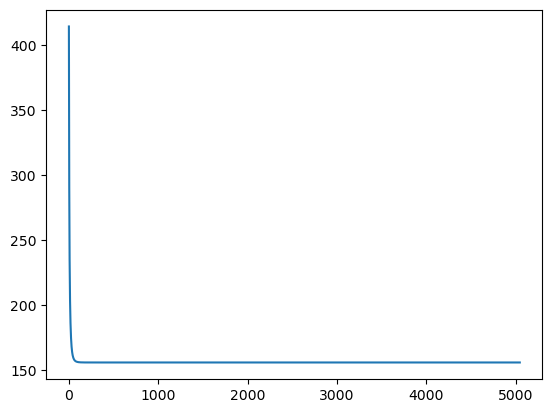

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000001EC2310>

In [20]:
plot(Js)

In [21]:
accuracy(β, X, y, T = 0.5) = sum((Predict(β, X)' .≥ T ).== y)/length(y)

accuracy (generic function with 2 methods)

In [22]:
accuracy(β, X_test, y_test)

0.6730769230769231

# Deep Learning Models

Obviously we will not define entire models in every case. Especially when models will became much more complicated than the simple perceptron. We will use [flux.jl](http://fluxml.ai/):

- [Flux](http://fluxml.ai/) is a Julia machine learning stack.
- Flux is lightweight, written entirely in Julia; it is trivial to hack it and build models suited for very specific cases. 
- Flux supports all the Julia's syntax; the vast majority of Julia's functions and macros could be used inside the model.
- Building of basic models is very easy and intuitive.

### Layers

Flux allows to define the layer on neural network in many different ways:

In [23]:
@time using Flux

  6.108096 seconds (19.43 M allocations: 1.291 GiB, 9.12% gc time, 40.10% compilation time)


In [24]:
W = rand(4, 8)
b = rand(4)
layer₁(x) = 1.0 ./ (1.0.+exp.(-W*x - b))

layer₁ (generic function with 1 method)

In [25]:
W

4×8 Matrix{Float64}:
 0.31563   0.313392  0.49704    0.357507  …  0.523942  0.316026  0.431855
 0.954646  0.975008  0.320083   0.895672     0.343086  0.870523  0.32069
 0.687538  0.891334  0.150119   0.581221     0.442772  0.926227  0.156826
 0.830742  0.82306   0.0420983  0.656566     0.278327  0.239333  0.940142

In [26]:
x = rand(8)
layer₁(x)

4-element Vector{Float64}:
 0.9037959528722758
 0.9359530127233557
 0.9430819917877764
 0.9479518238737041

We could also use the already implemented, most popular [types of layers](https://fluxml.ai/Flux.jl/stable/models/layers/#Basic-Layers-1):

In [27]:
layer₂(x) = σ.(W * x .+ b)
layer₂(x)

LoadError: MethodError: objects of type Matrix{Float64} are not callable
Use square brackets [] for indexing an Array.

In [28]:
layer₃ = Dense(8,4,σ)
layer₃(x)

LoadError: MethodError: objects of type Matrix{Float64} are not callable
Use square brackets [] for indexing an Array.

We could also define them on our own:

In [29]:
struct Poly
    W
    V
    b
end

Poly(in::Integer, out::Integer) =
  Poly((randn(out, in)),randn(out, in), (randn(out)))

# Overload call, so the object can be used as a function
(m::Poly)(x) = m.W * x.^2 + m.V*x .+ m.b

a = Poly(10, 5)

a(rand(10)) # => 5-element vector

5-element Vector{Float64}:
 -0.8338461558739707
  0.35711959617118627
 -2.561420517780591
 -1.605886243985195
 -0.31562784065460425

And then, to use such user-defined layer in the Flux, we must use the macro <tt>@functor </tt>. Without that we will not be able to use all the built-in functions, e.g.  gradient propagation or [GPU computing](https://fluxml.ai/Flux.jl/stable/gpu/):

In [30]:
Flux.@functor  Poly

In [31]:
gpu(a);

Obviously, our model will have more than one layer. Again, there are plenty of methods to do this:

In [32]:
Layer₁ = Dense(28^2, 32, relu)
Layer₂ = Dense(32, 10)
Layer₃ = softmax

softmax (generic function with 3 methods)

Function <tt>Chain</tt> allows us to merge multiple layers in the sequence:

In [33]:
chain = Chain(x -> x^2, x-> -x)
m₁ = Chain(Layer₁ , Layer₂, Layer₃) 

Chain(
  Dense(784, 32, relu),                 # 25_120 parameters
  Dense(32, 10),                        # 330 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 25_450 parameters, 99.664 KiB.

We could also define the model as a function composition:

In [34]:
m₂(x) = Layer₃(Layer₂(Layer₁(x)))

m₂ (generic function with 1 method)

In [35]:
m₃(x) = Layer₁ ∘ Layer₂ ∘ Layer₃  

m₃ (generic function with 1 method)

or pipeline:

In [36]:
m₄(x) = Layer₁(x) |> Layer₂  |> Layer₃ 

m₄ (generic function with 1 method)

### Cost Function; Regularization

[Goodfellow I., Bengio Y., Courville A. (2016), Deep Learning, Chapter 7](http://www.deeplearningbook.org/contents/regularization.html)

As it was mention in the last lecture, we cannot optimize the neural network directly; we must define and use a cost function $J(\theta)$.

We could define it on our own:

In [37]:
model = Dense(5,2)
x, y = rand(5), rand(2);
loss(ŷ, y) = sum((ŷ.- y).^2)/ length(y)
loss(model(x), y) 

0.014583981834245738

or use the one [implemented in Flux](https://github.com/FluxML/Flux.jl/blob/8f73dc6e148eedd11463571a0a8215fd87e7e05b/src/layers/stateless.jl):

In [38]:
Flux.mse(model(x),y)

0.014583981834245738

Well trained model will have the smallest possible <b>generalization error</b>:

[![](https://cdn-images-1.medium.com/max/1600/1*1woqrqfRwmS1xXYHKPMUDw.png)](https://buzzrobot.com/bias-and-variance-11d8e1fee627)


However, neural networks tends to overfit easily. In order to avoid that, we must use a proper <b>regularization</b> method. With a fine-tuned model we could overcome this problem and significantly reduce the error.

The most common methods are:

<b>penalization of the coefficients</b>:

One of the most common methods of regularization; It limit the capacity of the model to overfit by adding a parameter norm penalty in a form: 
     
$\tilde{J}(\theta) = J(\theta) + \alpha\Omega(\theta)$

Two most common methods are:
- $\Omega(\theta) = ||\theta||_1 = \sum_i{|\theta_i|}$     (<i>LASSO</i>, <i>$L_1$ regularization</i>)
- $\Omega(\theta) = ||\theta||_2^2 = \sum_i{\theta_i^2}$ (<i>Tikhonov regularization</i>, <i>Ridge regression</i>, <i>$L_2$ regularization</i>)

They implementation is [as follows](https://fluxml.ai/Flux.jl/stable/models/regularisation/):

In [39]:
using LinearAlgebra

In [40]:
L₁(θ) = sum(abs, θ) 
L₂(θ) = sum(abs2, θ) 

L₂ (generic function with 1 method)

In [41]:
J(x,y,W) = loss(model(x),y) + L₁(W)

J (generic function with 1 method)

In [42]:
J(x,y,W)

16.387486426865173

<b>Bagging (bootstrap aggregating)</b>:

From the initial dataset, $k$ sets are sampled uniformly with replacement. Then $k$  models are trained using the above sets. Final result is obtained by aggregating the output of the models.

<b>Dropout</b>:

In every iteration of the training, neurons are removed from the model with a probability $p$. Binary vector $\mu = [1,1,0,1,1,1,\dots,0,1]$ represent the neurons used in the training process in $i$-th iteration. The goal of the training process is to minimize the value of $E_\mu[J(\theta,\mu)]$ for every iteration. As a result, we obtain the unbiased estimator of a gradient function without the costly process of generating and training $k$ separated models.

Dropout is implemented as a [layer of model](https://fluxml.ai/Flux.jl/stable/models/layers/#Normalisation-and-Regularisation-1): 

In [43]:
model = Chain(Dense(28^2, 32, relu),
    Dropout(0.1),
Dense(32, 10),
BatchNorm(64, relu),
softmax)

Chain(
  Dense(784, 32, relu),                 # 25_120 parameters
  Dropout(0.1),
  Dense(32, 10),                        # 330 parameters
  BatchNorm(64, relu),                  # 128 parameters, plus 128
  NNlib.softmax,
)         # Total: 6 trainable arrays, 25_578 parameters,
          # plus 2 non-trainable, 128 parameters, summarysize 100.922 KiB.

### Optimization

[Goodfellow I., Bengio Y., Courville A. (2016), Deep Learning, Chapter 8](http://www.deeplearningbook.org/contents/optimization.html)

Choice of the proper optimization algorithm is the most important step during the neural network training. Cost function minimization is non-trivial task; there are plenty of serious problems which might derail the learning process:
- ill-conditioned Hessian matrix.
- local minimas, plateaus, etc.
- vanishing and exploding gradients

As a result vanilla stochastic gradient method might not be able to solve such problem. There are many modifications of SGD algorithm introduced to overcome these issues:
- SGD [(Robbins & Munro 1951)](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177729586)
- SGD with momentum [(Polyak, 1964)](http://www.mathnet.ru/php/archive.phtml?wshow=paper&jrnid=zvmmf&paperid=7713&option_lang=eng)
- SGD with  Nesterov momentum ([Nesterov, 1983](http://www.cis.pku.edu.cn/faculty/vision/zlin/1983-A%20Method%20of%20Solving%20a%20Convex%20Programming%20Problem%20with%20Convergence%20Rate%20O%28k%5E%28-2%29%29_Nesterov.pdf), [2005](https://www.math.ucdavis.edu/~sqma/MAT258A_Files/Nesterov-2005.pdf))
- AdaGrad (Adaptive Gradient Algorithm) [(Duchi et. al. 2011)](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
- ADAM (Adaptive Moment Estimation) [(Kingma & Ba, 2015)](https://arxiv.org/abs/1412.6980)



Flux allows to [calculate a gradient of every function](https://fluxml.ai/Flux.jl/stable/models/basics/):

In [44]:
f(x) = 3x^2 + 2x + 1

# df/dx = 6x + 2
df(x) = gradient(f, x)[1]

df(2) # 14.0 

# d²f/dx² = 6
d²f(x) = gradient(df, x)[1]

d²f(2) # 6.0 

LoadError: cannot define function df; it already has a value

Even if the function is not declared as a mathematical formula:

In [45]:
function pow(x, n)
    r = 1
    for i = 1:n
        r *= x
    end
    return r
end

pow (generic function with 1 method)

In [46]:
pow(2,4)

16

In [47]:
gradient(x -> pow(x, 3), 5)

(75.0,)

In [48]:
pow2(x, n) = n <= 0 ? 1 : x*pow2(x, n-1)

pow2 (generic function with 1 method)

In [49]:
gradient(x -> pow2(x, 3), 5)

(75.0,)

It is possible because of the efficient differentiation algorithm implemented in the [<tt>Zygote.jl</tt>](https://fluxml.ai/Zygote.jl/latest/) package. It uses the characteristic elements of the language, e.g. its compiler to find the derivatives of functions. A brief explanation how <tt>Zygote</tt> works is avalaible [here](https://github.com/MikeInnes/diff-zoo) and [here](https://arxiv.org/pdf/1810.07951.pdf).

### Automatic Differentiation

The key element of the neural networks training is finding a gradients. As we now from the previous lecture, naïve numerical approximation of derivatives by the definition:
$$\frac{df}{dx} = \lim_{h \to 0}\frac{f(x_0 +h) - f(x_0)}{h}$$
is a recipe for disaster. So, how we could find the derivatives on the computer?

It turns out, that even the most complicated function could be represented as a composition of some basic functions (sin,cos,log,etc.) and arithmetic operations. Knowing the derivatives of these basic functions, we could compute basically every derivative by using a <i>chain rule</i>:

$$
\frac{dy}{dx} = \frac{dy_1}{dx}*\frac{dy_2}{dy_1}*\dots*\frac{dy_{n-1}}{dy_{n-2}}*\frac{dy}{dy_{n-1}}
$$

There are two distinct methods of automatic differentiation:

- <b>Forward Accumulation</b> we start with a known value of $\frac{dy_0}{dx} = \frac{dx}{dx} = 1$. then we are computing the value of the next step $\frac{dy_1}{dx} = \frac{d_1}{dx} = 1$ and we continue this process, calculating the values of next elements of chain:$\frac{dy_{i+1}}{dy_i}$, until we reach a final step.

- <b>Backward Accumulation</b> we start with a known value of  $\frac{dy}{dy_n} = \frac{dy}{dy} = 1$, then we are finding the value of: $\frac{dy}{dy_n}$, $\frac{dy}{dy_{n-1}}$, ... $\frac{dy}{dy_1}$, $\frac{dy}{dx}$.  

## Zygote.jl

<tt>Zygote</tt> package is based around two crucial elements: macro <tt>@adjoint</tt> and function <tt>pullback</tt>. 

<tt>pullback</tt> returns two things, the value of original function $y = f(x)$ and <i>pullback</i> expression $ \mathcal{B}(\overline{y}) = \overline{y}  \frac{dy}{dx}$, where $\overline{y} = \frac{dl}{dy}$ is a predefined parameter for a given function $l$.  

In [50]:
using Zygote

In [51]:
y, back = Zygote.pullback(sin, π);

In [52]:
y

1.2246467991473532e-16

In [53]:
sin(y)

1.2246467991473532e-16

In [54]:
back(1)

(-1.0,)

In particular, for function <tt>gradient</tt>  $l = y = f(x)$ and  $\overline{y} = \frac{dy}{dl} = 1$:

In [55]:
back(1)

(-1.0,)

In [56]:
gradient(sin,π) == back(1)

true

Macro <tt>@adjoint</tt> allows us to compute custom adjoints and modify the derivation mechanism:

In [57]:
using Zygote: @adjoint

In [58]:
minus(a,b) = a - b

minus (generic function with 1 method)

In [59]:
gradient(minus,2,3)

(1.0, -1.0)

In [60]:
minus2(a,b) = a - b

minus2 (generic function with 1 method)

In [61]:
@adjoint minus2(a,b) = minus2(a,b), c̄ -> (nothing, -b^2)

In [62]:
gradient(minus2,2,3)

(nothing, -9.0)

 Obviously Flux have implemented [the most common optimization algorithms](https://fluxml.ai/Flux.jl/stable/training/optimisers/):

In [63]:
opt = ADAM(0.0001)

ADAM(0.0001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

### Model Training

Flux can control the entire learning process with a function <tt>train!</tt>:

In [64]:
Flux.train!(objective, data, opt)

LoadError: UndefVarError: objective not defined

However, <tt>train!</tt> works for only one epoch. If we need to train the model for more than one epoch, we must either modify the dataset:

In [65]:
using Base.Iterators: repeated
dataset = repeated((x, y), 200)

Base.Iterators.Take{Base.Iterators.Repeated{Tuple{Vector{Float64}, Float64}}}(Base.Iterators.Repeated{Tuple{Vector{Float64}, Float64}}(([0.47911658139882374, 0.8449283282540289, 0.378614082646496, 0.7258049675933954, 0.536806139995963], 1.2246467991473532e-16)), 200)

or use the macro <tt>@epochs</tt>:

In [66]:
Flux.@epochs 2 println("hello")

hello
hello


┌ Info: Epoch 1
└ @ Main C:\Users\barto\.julia\packages\Flux\qAdFM\src\optimise\train.jl:143
┌ Info: Epoch 2
└ @ Main C:\Users\barto\.julia\packages\Flux\qAdFM\src\optimise\train.jl:143


In flux we could also define the callbacks, which will help us control the learning process:

In [67]:
evalcb = () -> @show(loss(tX, tY))

#23 (generic function with 1 method)

## Example

In [68]:
using Flux, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated
using MLDatasets
using ImageCore

It is time to wrap everything up. Let start with preparing a dataset. Firstly, we will download it:

In [69]:
MNIST.download();

stdin> y
This program has requested access to the data dependency MNIST.
which is not currently installed. It can be installed automatically, and you will not see this message again.

Dataset: THE MNIST DATABASE of handwritten digits
Authors: Yann LeCun, Corinna Cortes, Christopher J.C. Burges
Website: http://yann.lecun.com/exdb/mnist/

[LeCun et al., 1998a]
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner.
    "Gradient-based learning applied to document recognition."
    Proceedings of the IEEE, 86(11):2278-2324, November 1998

The files are available for download at the offical
website linked above. Note that using the data
responsibly and respecting copyright remains your
responsibility. The authors of MNIST aren't really
explicit about any terms of use, so please read the
website to make sure you want to download the
dataset.



Do you want to download the dataset from ["https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz", "https://ossci-datasets.s3.amazona

┌ Info: Downloading
│   source = https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
│   dest = C:\Users\barto\.julia\datadeps\MNIST\train-labels-idx1-ubyte.gz
│   progress = 1.0
│   time_taken = 0.11 s
│   time_remaining = 0.0 s
│   average_speed = 266.076 KiB/s
│   downloaded = 28.204 KiB
│   remaining = 0 bytes
│   total = 28.204 KiB
└ @ HTTP C:\Users\barto\.julia\packages\HTTP\aTjcj\src\download.jl:131
┌ Info: Downloading
│   source = https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
│   dest = C:\Users\barto\.julia\datadeps\MNIST\t10k-labels-idx1-ubyte.gz
│   progress = 1.0
│   time_taken = 0.0 s
│   time_remaining = 0.0 s
│   average_speed = ∞ B/s
│   downloaded = 4.436 KiB
│   remaining = 0 bytes
│   total = 4.436 KiB
└ @ HTTP C:\Users\barto\.julia\packages\HTTP\aTjcj\src\download.jl:131
┌ Info: Downloading
│   source = https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
│   dest = C:\Users\barto\.julia\datadeps\MNI

In [70]:
imgs, labels = MNIST.traindata();

Lets take a look at example picture:

In [71]:
MNIST.convert2image(imgs)[:,:,1]

In [72]:

# Classify MNIST digits with a simple multi-layer-perceptron

# Stack images into one large batch
X = reshape(float.(imgs),size(imgs,1) * size(imgs,2),size(imgs,3))

# One-hot-encode the labels
Y = onehotbatch(labels, 0:9) 

10×60000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

Then we must define the model:

In [73]:
m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax) 

loss(x, y) = crossentropy(m(x), y)

accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

dataset = repeated((X, Y), 200)
evalcb = () -> @show(loss(X, Y))
opt = ADAM()


accuracy(X, Y)

0.1113

It is time for some training:

In [74]:
Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 10))

loss(X, Y) = 2.2117133f0
loss(X, Y) = 0.5954922f0
loss(X, Y) = 0.37429672f0
loss(X, Y) = 0.31271383f0
loss(X, Y) = 0.27645364f0


We could save results in the [<tt>BSON</tt>](https://github.com/JuliaIO/BSON.jl) format:

In [75]:
using BSON

In [76]:
BSON.@save "MNIST.bson" m

and obviosly load:

In [77]:
BSON.@load "MNIST.bson" m

Finally, we could take the look at the results:

In [78]:
# Test set accuracy
timgs, tlabels = MNIST.testdata();

#Reshape data
tX = reshape(float.(timgs),size(timgs,1) * size(timgs,2) ,size(timgs,3))

# One-hot-encode the labels
tY = onehotbatch(tlabels, 0:9) 

accuracy(tX, tY)

0.9242

### Hyperparameters Tuning

During the training process, only the weights $\theta$ are optimized. All the other parameters of the neural network (activation functions, regularization methods, optimization algorithm and its parameters, learning rate, etc.) are predefined. In order to find the best model, we must carefully choose them. We might do this with a plenty of different methods:
- using the examples from the literature
- randomly generating and comparing different combinations of hyperparameters
- building a model able to [learn the best parameters for our task](https://arxiv.org/abs/2004.05439)
- searching the hyperparameters space

## Extra Homework

1. Tune the hyperparameters of the network presented during the lecture; try to find the combination which will give you the highest accuracy <b>(5 points)</b>.
2. During the lecture we indtroduce the <i>dual numbers</i>.We define them as expressions in the form: $z = a + \epsilon b$, where $a,b \in \mathbb{R}$ and  $\epsilon^2 = 0$. For every polynomial: $f(x) = a_0 + a_1x + a_2x^2 + \dots + a_nx^n$ its value for the dual number $z$ is equal to: $f(z) = f(a) + bf'(a)\epsilon$, prove it <b>(5 points)</b>.